In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyarrow import parquet as pq
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from joblib import Parallel, delayed

import sys
sys.path.append("..")
from pLMtrainer import utils

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
### now need to use argmax for cls preds to get class labels. ###

### MISC

In [18]:
parquet_path = "../data/frustration/v4_frustration.parquet.gzip"

In [19]:
df = pq.read_table(parquet_path).to_pandas()
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id,frst_class_3
0,AF-A0A009EQP3-F1-model_v4_TED02,MKESLRLRLDQLSDRHEELTALLADVEVISDNKRFRQLSREHNDLT...,"[Y, L, E, I, R, A, G, T, G, G, D, E, A, A, I, ...","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[0.235, 1.632, -0.844, 1.365, 0.282, -0.384, 0...","[9, 6, 11, 6, 9, 10, 9, 9, 9, 11, 12, 13, 9, 8...",train,3.30.70,"[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, ..."
1,AF-A0A009F754-F1-model_v4_TED02,MANPAQLVRHKLLNTFFSRHSVWFACITIAVIFTIFHIGYEPRYIY...,"[R, I, L, I, G, N, E, Q, C, T, Q, P, Y, S, A, ...","[164, 165, 166, 167, 168, 169, 170, 171, 172, ...","[-1.068, 1.469, -0.317, 1.098, -0.663, -0.771,...","[12, 6, 10, 7, 11, 11, 7, 10, 3, 9, 13, 11, 9,...",train,3.20.20,"[0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 2, ..."


In [20]:
len(df)

982852

In [45]:
df_train = df[df["set"] == "train"]
df_val = df[df["set"] == "val"]
df_test = df[df["set"] == "test"]

In [21]:
np.concatenate(df["res_idx"].to_numpy()).shape

(186414569,)

In [ ]:
np.concatenate(df_train["res_idx"].to_numpy()).shape, \
np.concatenate(df_val["res_idx"].to_numpy()).shape, \
np.concatenate(df_test["res_idx"].to_numpy()).shape

((170311084,), (5264676,), (10838809,))

In [56]:
np.where(np.concatenate(df_train["res_idx"].to_numpy()) <= 512)[0].shape, \
np.where(np.concatenate(df_val["res_idx"].to_numpy()) <= 512)[0].shape, \
np.where(np.concatenate(df_test["res_idx"].to_numpy()) <= 512)[0].shape

((157560113,), (4923399,), (9583226,))

In [33]:
res_count = [len(s) for s in df["full_seq"].tolist()]
res_count = np.array(res_count)
res_count

array([362, 556, 255, ..., 422, 285, 252], shape=(982852,))

In [34]:
sum(res_count)

np.int64(442719427)

In [35]:
frst_count = [len(s) for s in df["res_seq"]]
frst_count = np.array(frst_count)
frst_count

array([163, 360, 108, ..., 108,  67,  96], shape=(982852,))

In [36]:
sum(frst_count)

np.int64(186414569)

In [37]:
used_frst_res = [sum(s <= 512) for s in df["res_idx"].tolist()]
sum(used_frst_res)

np.int64(172066738)

In [11]:
sum(used_frst_res) / sum(frst_count), sum(used_frst_res) / sum(res_count)

(np.float64(0.9758412069176846), np.float64(0.4108945912599403))

### FNN PREDS

In [3]:
FNN_test = np.load("../data/cluster_runs/FNN_test_preds.npz")
FNN_test.files

['regr_preds',
 'cls_preds',
 'regr_targets',
 'cls_targets',
 'masked_regr_preds',
 'masked_cls_preds',
 'masked_regr_targets',
 'masked_cls_targets']

In [4]:
FNN_test["masked_regr_preds"].shape

(10432095,)

In [5]:
FNN_report = classification_report(FNN_test["masked_cls_targets"], 
                                   FNN_test["masked_cls_preds"], 
                                   labels=range(1, 21), digits=4, zero_division=0)

In [6]:
print(FNN_report)

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       810
           2     0.0000    0.0000    0.0000      1003
           3     0.0000    0.0000    0.0000      2546
           4     0.3333    0.0001    0.0002      8183
           5     0.0822    0.0001    0.0003     41605
           6     0.2510    0.0078    0.0152    216259
           7     0.4785    0.3825    0.4252   1159955
           8     0.4975    0.6363    0.5584   1711433
           9     0.3675    0.3017    0.3314   1092732
          10     0.2695    0.1596    0.2005   1159851
          11     0.3588    0.4364    0.3938   1677849
          12     0.3642    0.4596    0.4064   1796416
          13     0.3754    0.4616    0.4140   1110193
          14     0.1770    0.0143    0.0264    310869
          15     0.0890    0.0066    0.0123     74789
          16     0.1578    0.1014    0.1235     33774
          17     0.0000    0.0000    0.0000     19407
          18     0.0000    

In [7]:
spearmanr(FNN_test["masked_regr_targets"], FNN_test["masked_regr_preds"])

SignificanceResult(statistic=np.float64(0.7772067212476484), pvalue=np.float64(0.0))

In [8]:
mean_absolute_error(FNN_test["masked_regr_targets"], FNN_test["masked_regr_preds"])

0.4570425748825073

In [9]:
r2_score(FNN_test["masked_regr_targets"], FNN_test["masked_regr_preds"])

0.6014403104782104

Text(0, 0.5, 'FNN Predicted frustration')

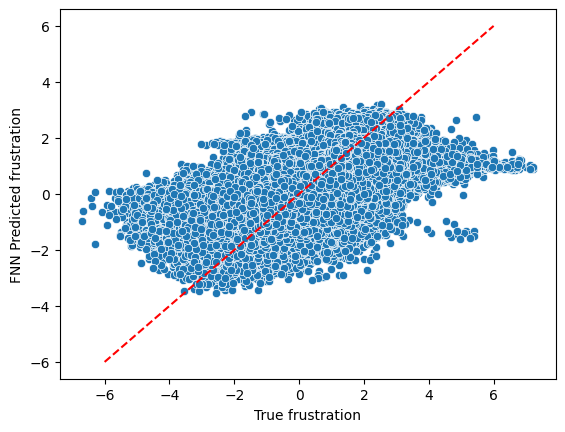

In [10]:
sns.scatterplot(x=FNN_test["masked_regr_targets"], y=FNN_test["masked_regr_preds"], color="C0")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("FNN Predicted frustration")

Text(39.222222222222214, 0.5, 'FNN Predicted frustration')

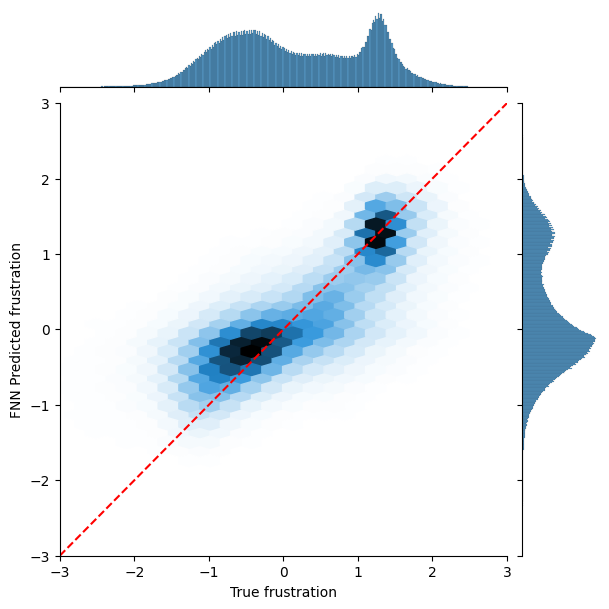

In [11]:
sns.jointplot(x=FNN_test["masked_regr_targets"], y=FNN_test["masked_regr_preds"], kind="hex", xlim=(-3,3), ylim=(-3,3), color="C0")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("FNN Predicted frustration")

### CNN PREDS

In [2]:
CNN_test = np.load("../data/it2/full_train_preds.npz")
CNN_test.files

['full_seqs',
 'masks',
 'regr_preds',
 'cls_preds',
 'regr_targets',
 'cls_targets',
 'masked_regr_preds',
 'masked_cls_preds',
 'masked_regr_targets',
 'masked_cls_targets']

In [4]:
CNN_test["full_seqs"].shape, CNN_test["masks"].shape, CNN_test["regr_preds"].shape, CNN_test["masked_regr_preds"].shape

((56892,), (56892, 512), (56892, 512), (9575120,))

In [5]:
padded_seqs = []
for seq in CNN_test["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
padded_seqs.shape

(56892,)

In [6]:
CNN_test["masks"].shape

(56892, 512)

In [7]:
seq_array = np.array([list(seq) for seq in padded_seqs])
seq_array.shape

(56892, 512)

In [8]:
masked_residues = seq_array[CNN_test["masks"]]
masked_residues.shape

(9575120,)

In [9]:
masked_residues

array(['A', 'K', 'A', ..., 'E', 'Y', 'R'], shape=(9575120,), dtype='<U1')

In [32]:
cls_preds = pd.cut(CNN_test["masked_regr_preds"].astype(float), bins=[-np.inf, -1, 0.55, np.inf], labels=[0,1,2])

In [33]:
cls_preds

[1, 2, 1, 1, 1, ..., 2, 1, 1, 1, 2]
Length: 9575120
Categories (3, int64): [0 < 1 < 2]

In [10]:
CNN_report = classification_report(CNN_test["masked_cls_targets"], 
                                   CNN_test["masked_cls_preds"], 
                                   labels=range(3), digits=4, zero_division=0)

In [11]:
print(CNN_report)

              precision    recall  f1-score   support

           0     0.6038    0.4058    0.4854   1079124
           1     0.7576    0.8779    0.8133   4868864
           2     0.8892    0.7863    0.8346   3627132

    accuracy                         0.7900   9575120
   macro avg     0.7502    0.6900    0.7111   9575120
weighted avg     0.7901    0.7900    0.7844   9575120



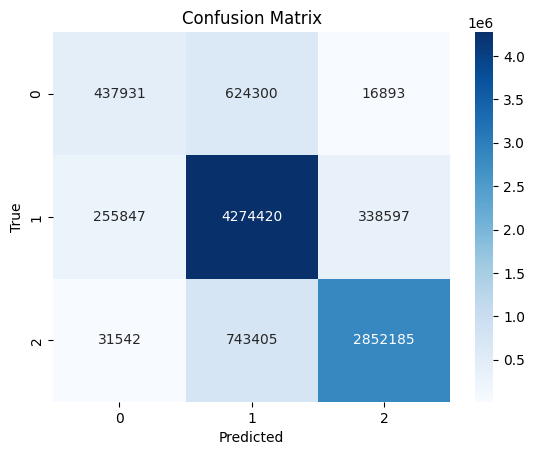

In [12]:
# make a confusion matrix
confusion_matrix = pd.crosstab(CNN_test["masked_cls_targets"], CNN_test["masked_cls_preds"], rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [13]:
spearmanr(CNN_test["masked_regr_targets"], CNN_test["masked_regr_preds"])

SignificanceResult(statistic=np.float64(0.8221311282052517), pvalue=np.float64(0.0))

In [14]:
mean_absolute_error(CNN_test["masked_regr_targets"], CNN_test["masked_regr_preds"])

0.3990024924278259

In [15]:
r2_score(CNN_test["masked_regr_targets"], CNN_test["masked_regr_preds"])

0.6751981973648071

Text(0, 0.5, 'CNN Predicted frustration')

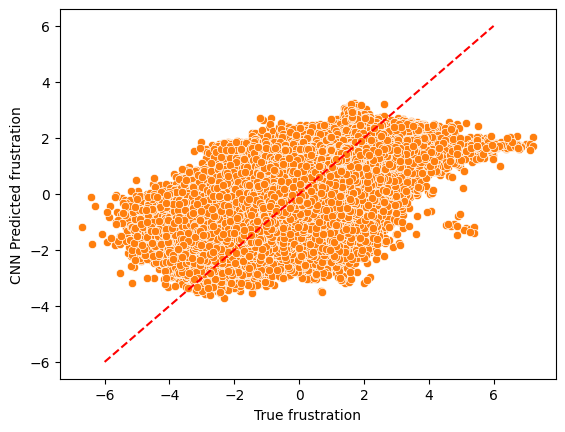

In [16]:
sns.scatterplot(x=CNN_test["masked_regr_targets"], y=CNN_test["masked_regr_preds"], color="C1")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("CNN Predicted frustration")

Text(39.222222222222214, 0.5, 'CNN Predicted frustration')

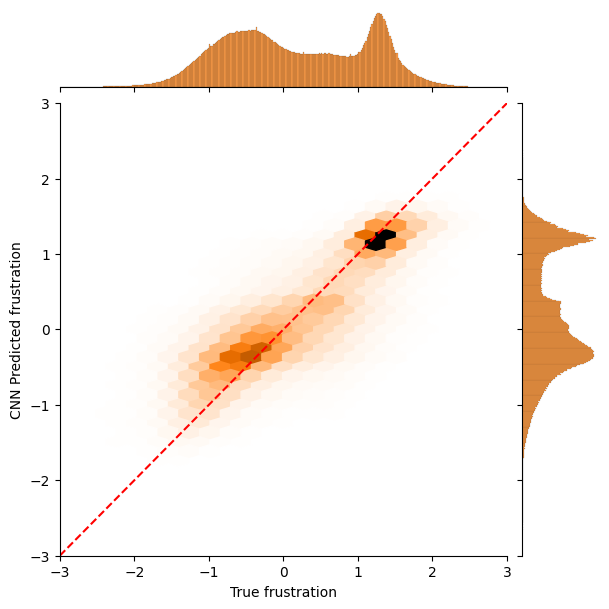

In [17]:
sns.jointplot(x=CNN_test["masked_regr_targets"], y=CNN_test["masked_regr_preds"], kind="hex", xlim=(-3,3), ylim=(-3,3), color="C1")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("CNN Predicted frustration")

In [18]:
mask = CNN_test["cls_targets"] != 0

In [19]:
pp_spearman = Parallel(n_jobs=-1)(
    delayed(spearmanr)(targets[m], preds[m])
    for preds, targets, m in zip(CNN_test["regr_preds"], CNN_test["regr_targets"], mask)
)
pp_spearman = np.array(pp_spearman)

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs

<Axes: ylabel='Count'>

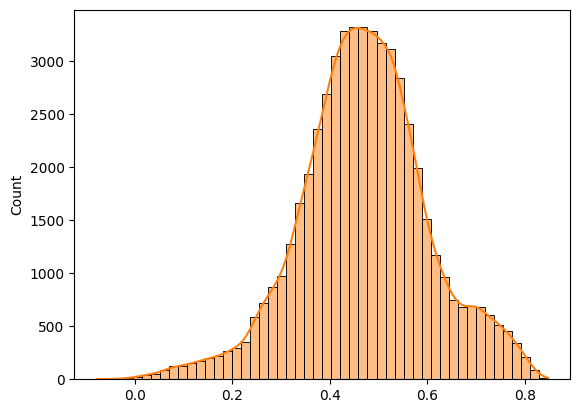

In [20]:
sns.histplot(pp_spearman[:, 0], bins=50, color="C1", kde=True)

In [21]:
sum(pp_spearman[:, 0] <= 0)

np.int64(23)

In [42]:
def mae_row(targets, preds):
    if len(targets) == 0 or len(preds) == 0:
        return np.nan
    return mean_absolute_error(targets, preds)

In [43]:
pp_mae = Parallel(n_jobs=-1)(
    delayed(mae_row)(targets[m], preds[m])
    for preds, targets, m in zip(CNN_test["regr_preds"], CNN_test["regr_targets"], mask)
)
pp_mae = np.array(pp_mae)

<Axes: ylabel='Count'>

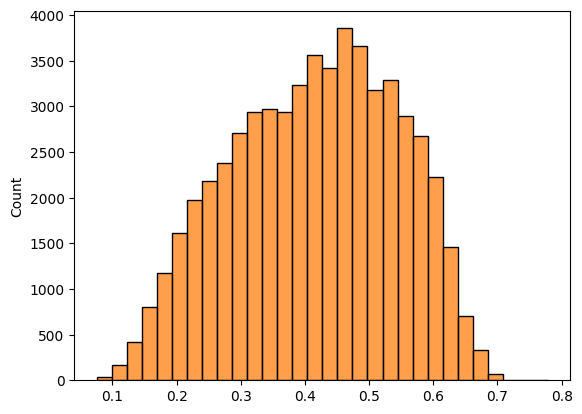

In [44]:
sns.histplot(pp_mae, bins=30, color="C1")

In [18]:
res_df = pd.DataFrame({"regr_pred": CNN_test["masked_regr_preds"],
                       "true_reg": CNN_test["masked_regr_targets"],
                       "cls_pred": CNN_test["masked_cls_preds"],
                       "cls_target": CNN_test["masked_cls_targets"],
                       "residue": masked_residues,
                       })
res_df

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,regr_pred,true_reg,cls_pred,cls_target,residue
0,0.100037,-0.879,1,1,A
1,0.864258,1.250,2,2,K
2,0.275391,-0.937,1,1,A
3,-0.466553,1.204,1,2,E
4,0.312500,0.978,1,2,E
...,...,...,...,...,...
9575115,1.248047,1.149,2,2,L
9575116,-0.979980,-1.287,0,0,E
9575117,-0.207275,-0.010,1,1,E
9575118,-0.739746,-1.478,0,0,Y


In [24]:
res_df_sub = res_df.sample(1000000, random_state=42)
res_df_sub

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,regr_pred,true_reg,cls_pred,cls_target,residue
3387255,-1.188477,0.104,0,1,W
4535045,-0.702148,-1.219,1,0,N
6532567,-0.304443,1.173,1,2,Q
2193737,-0.363281,-0.441,1,1,K
5278402,1.172852,1.326,2,2,V
...,...,...,...,...,...
6851893,-0.779297,-1.144,1,0,K
9177927,-0.482178,-0.660,1,1,E
3907879,-0.391357,-1.408,1,0,Q
1066758,-0.487061,-0.815,1,1,G


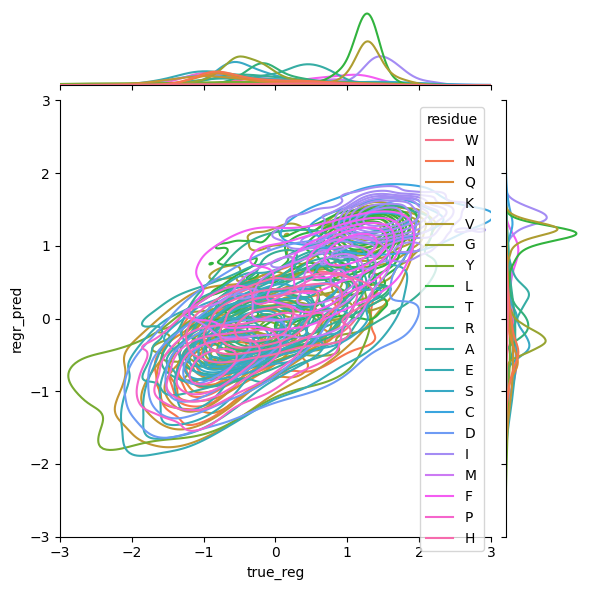

In [22]:
sns.jointplot(data=res_df_sub, x="true_reg", y="regr_pred", hue="residue", kind="kde", xlim=(-3,3), ylim=(-3,3))

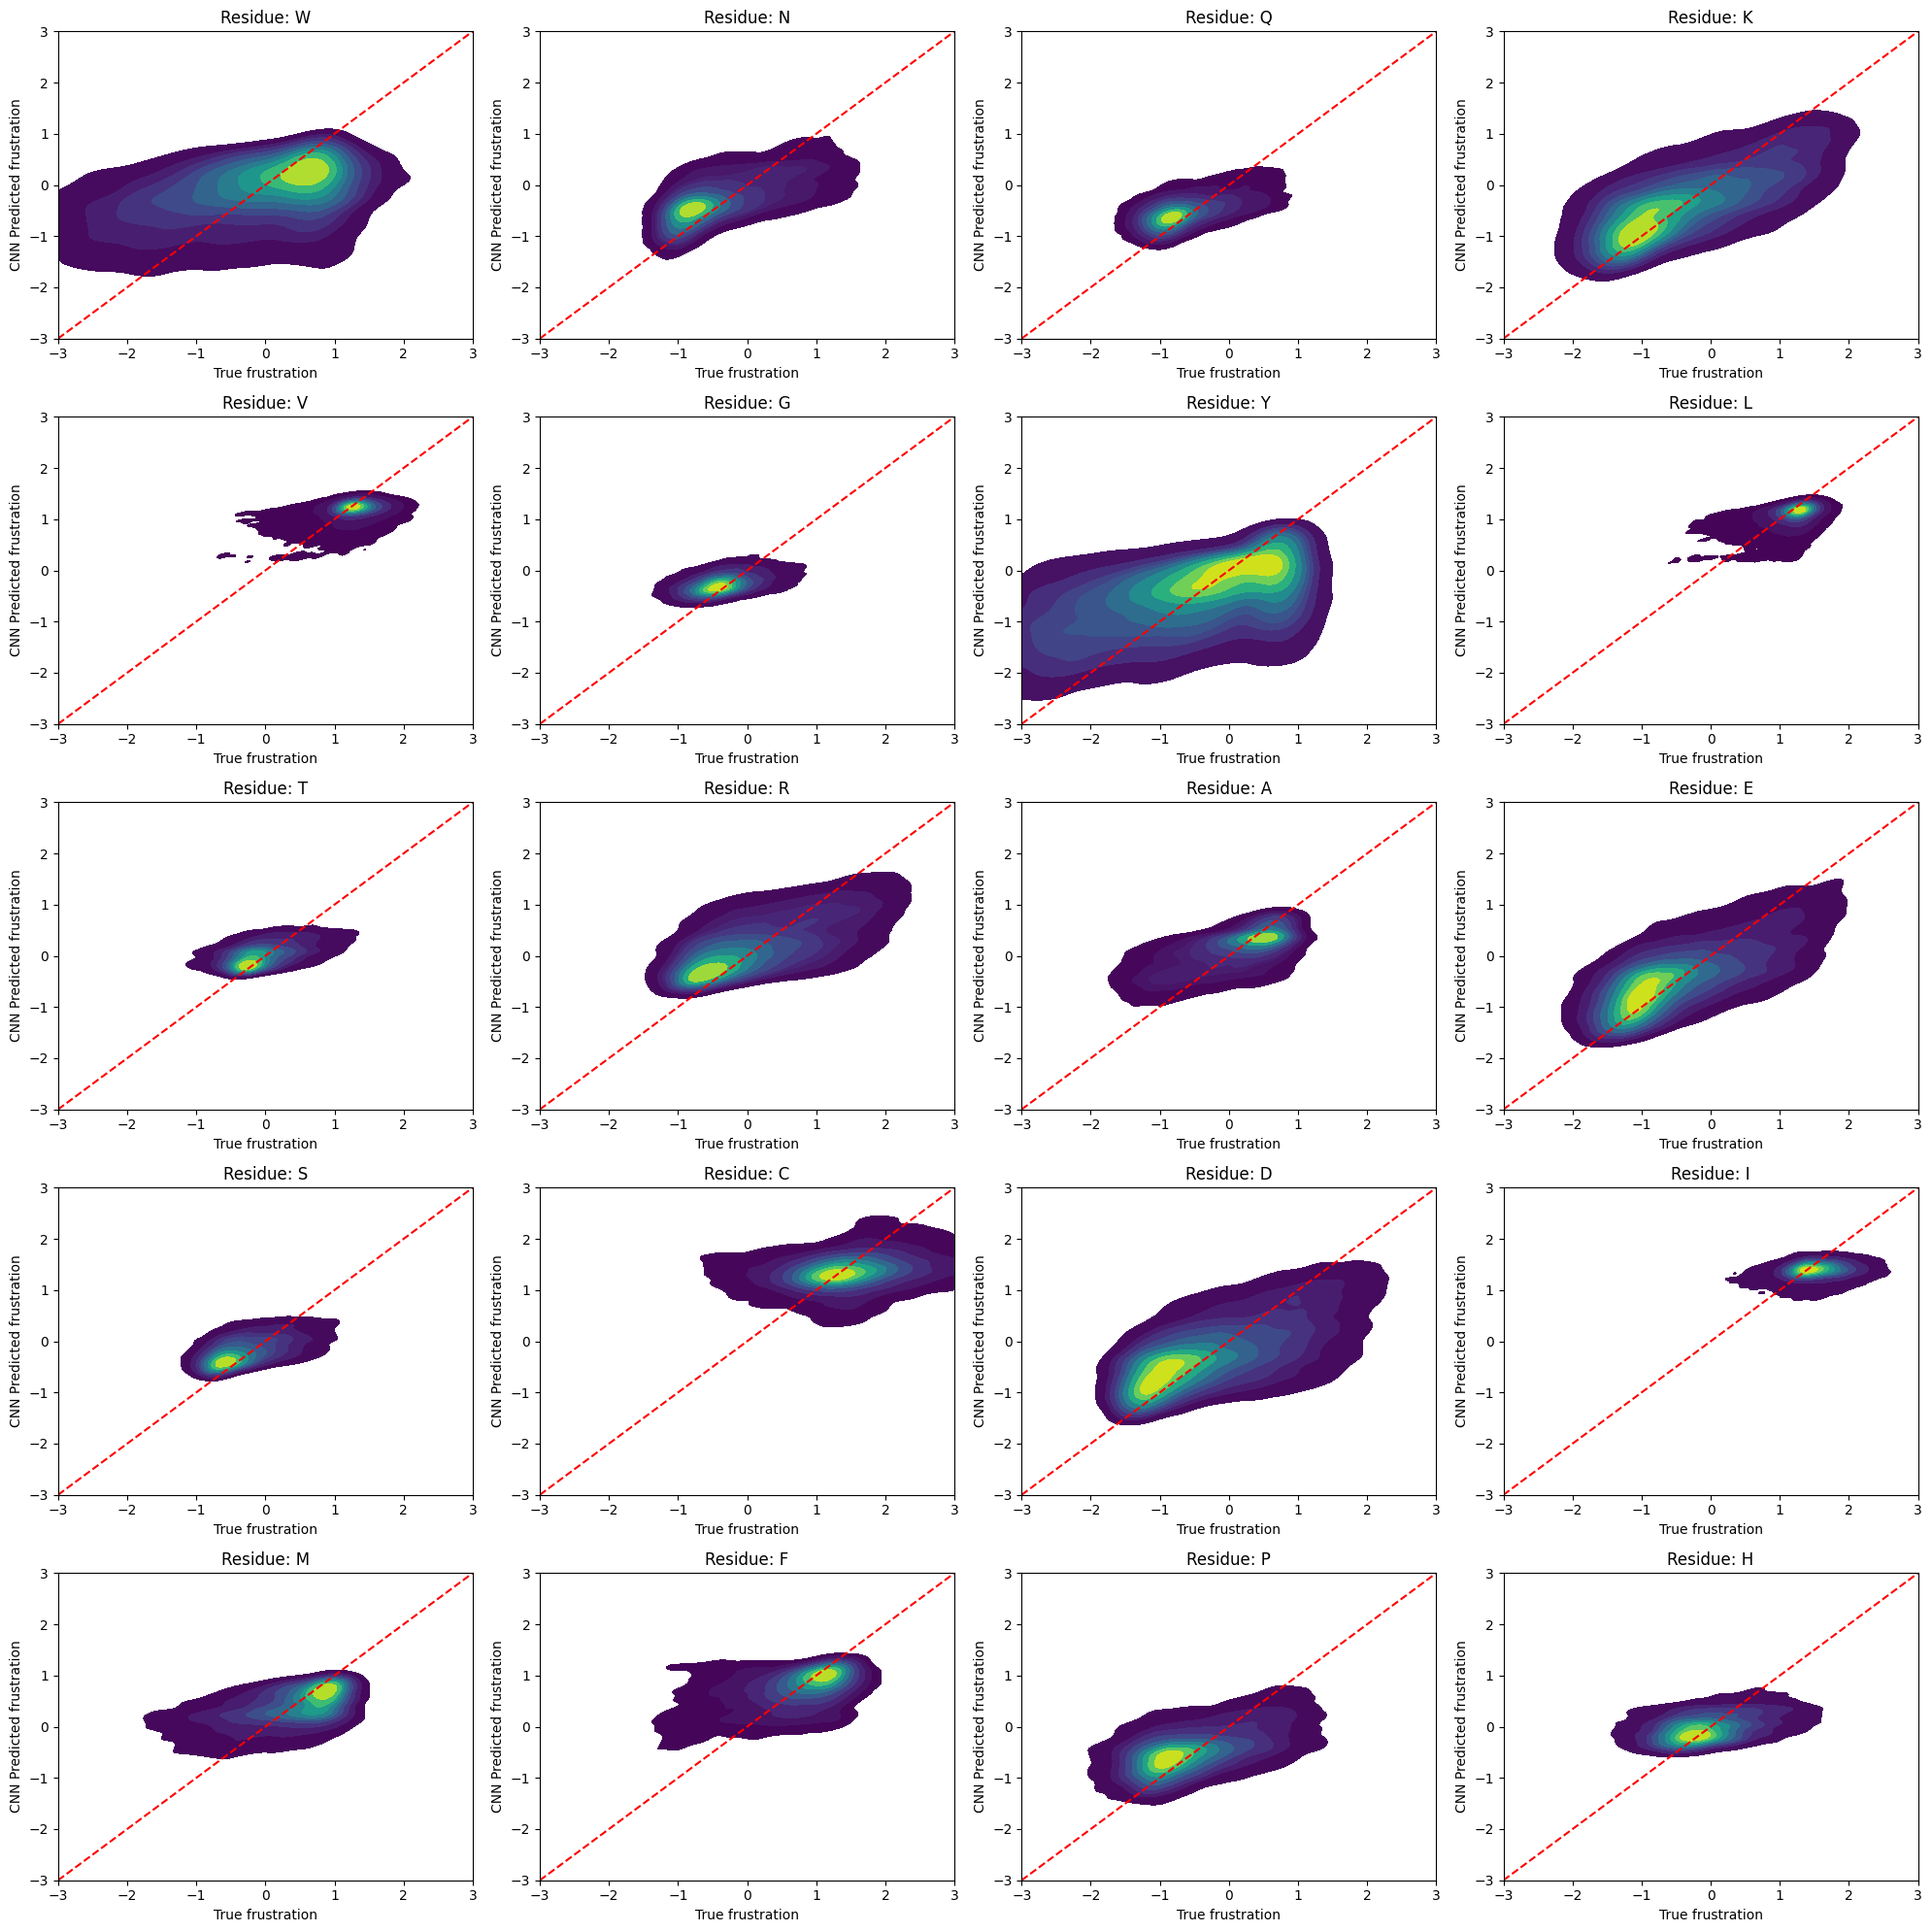

In [ ]:
#make a fig with 20 subplots 5rows and 4 columns showing jointplots for each residue type
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    ax = axes[i // 4, i % 4]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    sns.kdeplot(data=subset, x="true_reg", y="regr_pred", fill=True, ax=ax, cmap="viridis")
    ax.plot([-3, 3], [-3, 3], color="red", linestyle="--")
    ax.set_title(f'Residue: {residue}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("True frustration")
    ax.set_ylabel("CNN Predicted frustration")
plt.tight_layout()
plt.show()

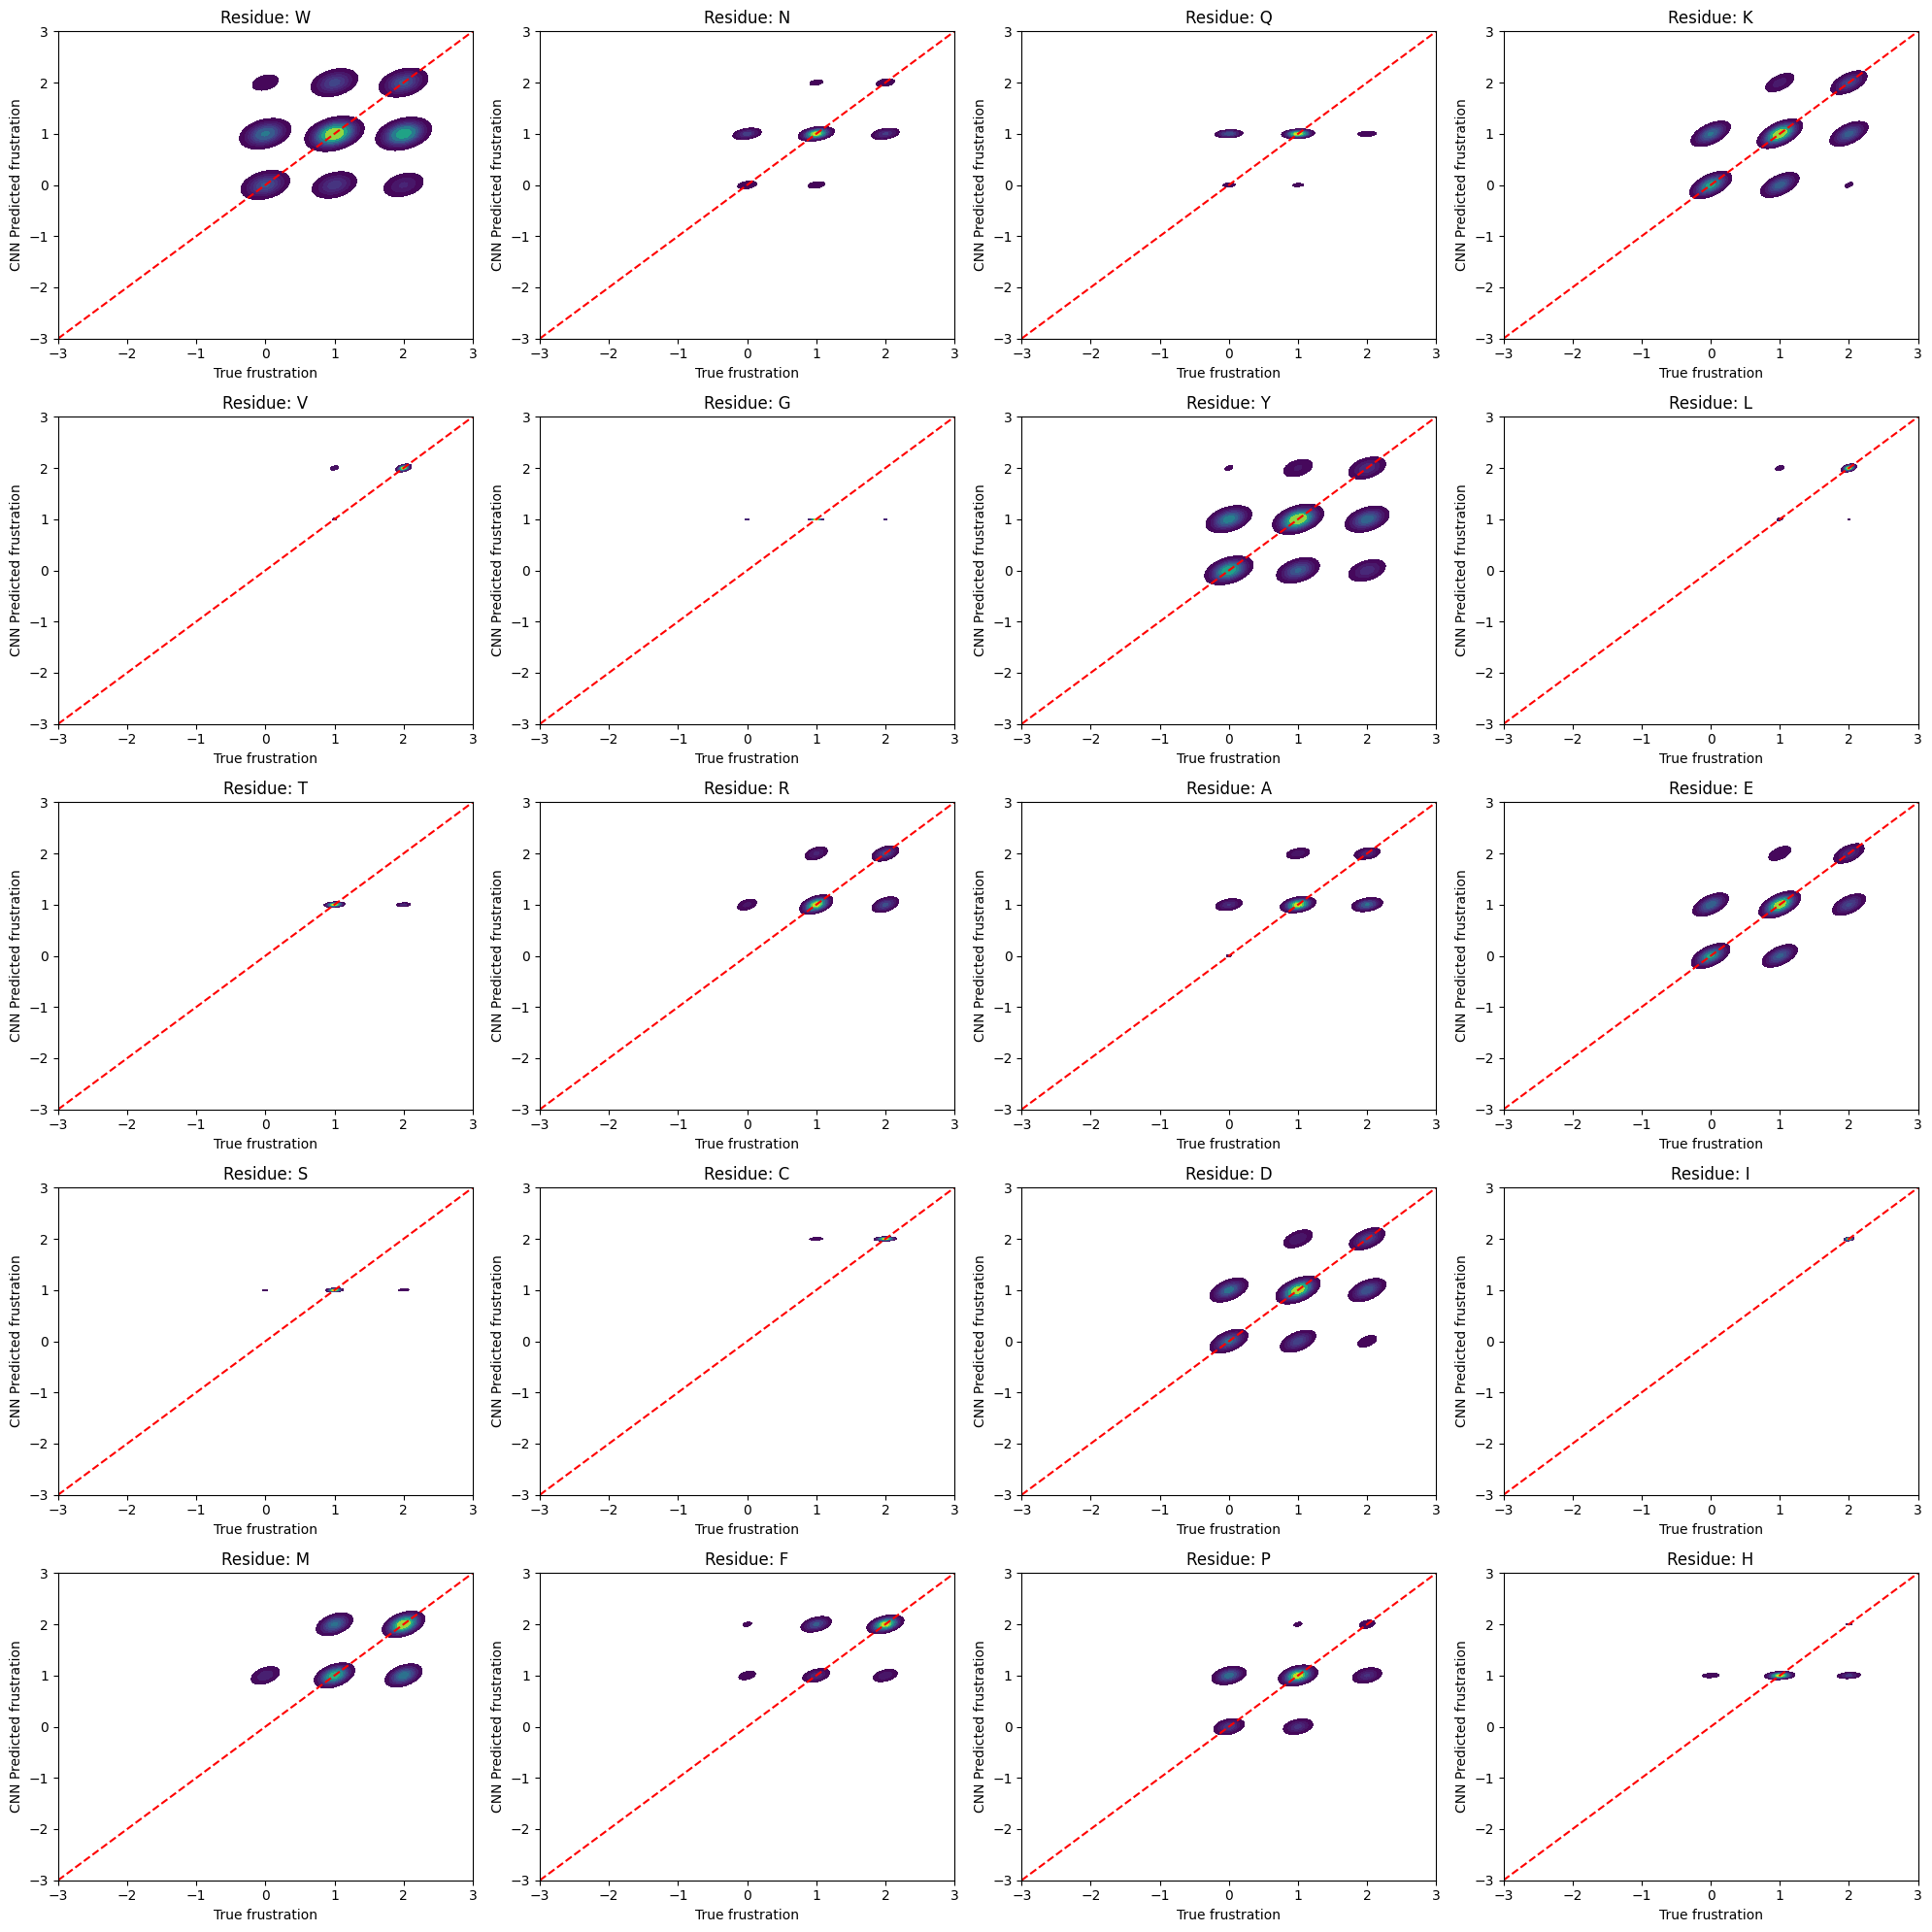

In [27]:
#make a fig with 20 subplots 5rows and 4 columns showing jointplots for each residue type
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    ax = axes[i // 4, i % 4]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    sns.kdeplot(data=subset, x="cls_target", y="cls_pred", fill=True, ax=ax, cmap="viridis")
    ax.plot([-3, 3], [-3, 3], color="red", linestyle="--")
    ax.set_title(f'Residue: {residue}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("True frustration")
    ax.set_ylabel("CNN Predicted frustration")
plt.tight_layout()
plt.show()

In [28]:
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    subset = res_df_sub[res_df_sub["residue"] == residue]
    cls_report = classification_report(subset["cls_target"], subset["cls_pred"], labels=range(3), digits=4, zero_division=0)
    print(f"Residue: {residue}")
    print(cls_report)

Residue: W
              precision    recall  f1-score   support

           0     0.4947    0.3980    0.4411      2832
           1     0.4999    0.7210    0.5905      5846
           2     0.5152    0.2685    0.3530      4242

    accuracy                         0.5016     12920
   macro avg     0.5033    0.4625    0.4615     12920
weighted avg     0.5038    0.5016    0.4798     12920

Residue: N
              precision    recall  f1-score   support

           0     0.5733    0.1752    0.2684      6894
           1     0.7566    0.9563    0.8448     34694
           2     0.6464    0.1868    0.2898      6146

    accuracy                         0.7444     47734
   macro avg     0.6588    0.4394    0.4677     47734
weighted avg     0.7159    0.7444    0.6901     47734

Residue: Q
              precision    recall  f1-score   support

           0     0.5374    0.0880    0.1512      7434
           1     0.7601    0.9783    0.8555     26040
           2     0.5000    0.0047    0.009

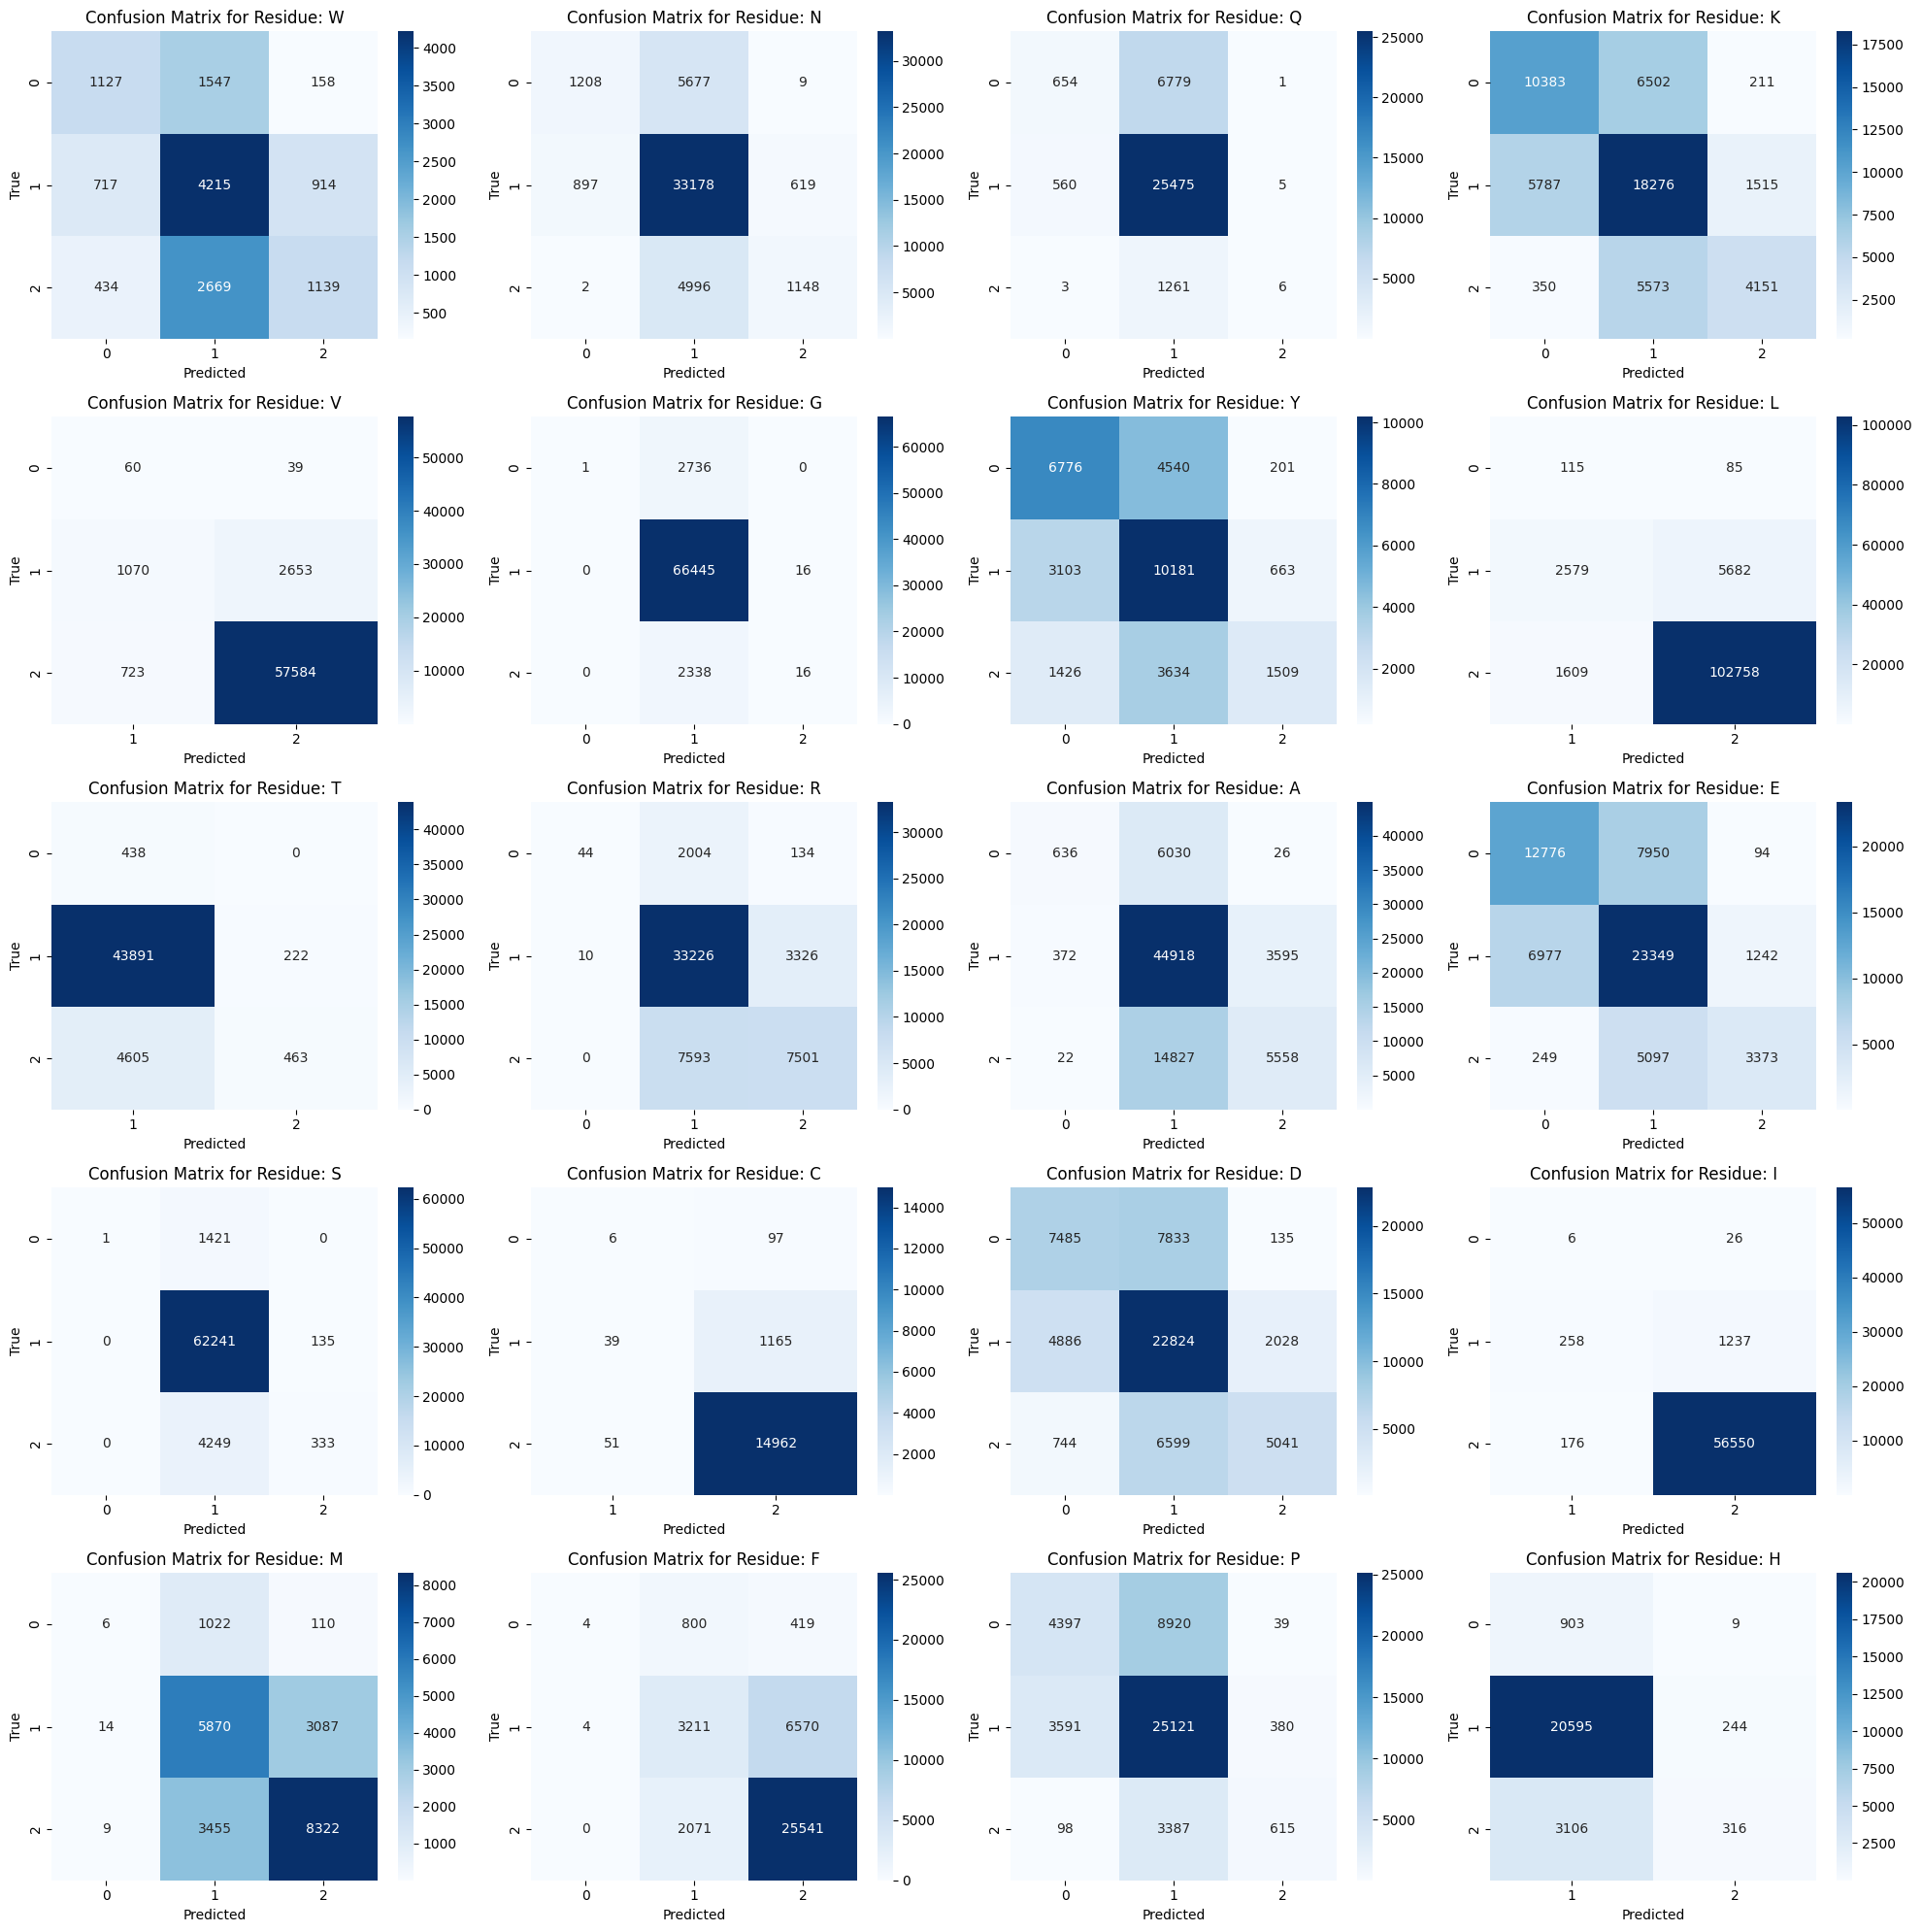

In [29]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    subset = res_df_sub[res_df_sub["residue"] == residue]
    confusion_matrix = pd.crosstab(subset["cls_target"], subset["cls_pred"], rownames=['True'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'Confusion Matrix for Residue: {residue}')
plt.tight_layout()
plt.show()

### Lin & Log Regression

In [21]:
LLR_test = np.load("../data/cluster_runs/baselines_preds_targets_reg_cls.npz")
LLR_test.files

['regr_preds',
 'cls_preds',
 'regr_targets',
 'cls_targets',
 'masked_regr_preds',
 'masked_cls_preds',
 'masked_regr_targets',
 'masked_cls_targets']

In [22]:
LLR_test["masked_regr_preds"].shape

(10432095,)

In [23]:
LLR_report = classification_report(LLR_test["masked_cls_targets"], 
                                   LLR_test["masked_cls_preds"], 
                                   labels=range(1, 21), digits=4, zero_division=0)

In [24]:
print(LLR_report)

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000       810
           2     0.0163    0.0040    0.0064      1003
           3     0.0368    0.0094    0.0150      2546
           4     0.0793    0.0434    0.0561      8183
           5     0.0916    0.0101    0.0182     41605
           6     0.1857    0.0309    0.0530    216259
           7     0.4913    0.3480    0.4074   1159955
           8     0.4705    0.6282    0.5380   1711433
           9     0.3090    0.2809    0.2943   1092732
          10     0.2229    0.1325    0.1662   1159851
          11     0.3462    0.4248    0.3815   1677849
          12     0.3424    0.3936    0.3662   1796416
          13     0.3326    0.4123    0.3682   1110193
          14     0.1668    0.0278    0.0476    310869
          15     0.1074    0.0185    0.0316     74789
          16     0.1227    0.0640    0.0841     33774
          17     0.1545    0.1022    0.1230     19407
          18     0.0475    

In [25]:
spearmanr(LLR_test["masked_regr_targets"], LLR_test["masked_regr_preds"])

SignificanceResult(statistic=np.float64(0.6731945387921586), pvalue=np.float64(0.0))

In [26]:
mean_absolute_error(LLR_test["masked_regr_targets"], LLR_test["masked_regr_preds"])

0.5416211485862732

In [27]:
r2_score(LLR_test["masked_regr_targets"], LLR_test["masked_regr_preds"])

0.46548938751220703

Text(0, 0.5, 'LLR Predicted frustration')

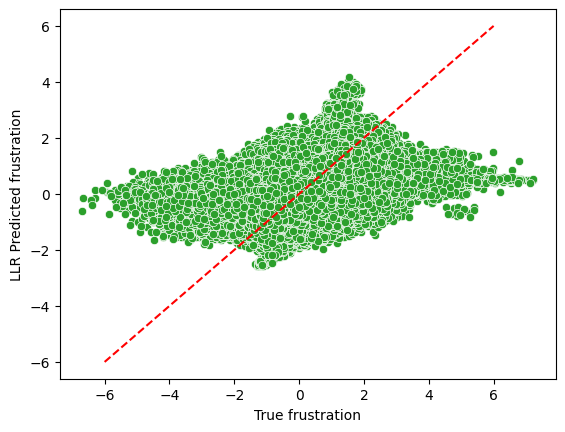

In [28]:
sns.scatterplot(x=LLR_test["masked_regr_targets"], y=LLR_test["masked_regr_preds"], color="C2")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("LLR Predicted frustration")

Text(39.222222222222214, 0.5, 'LLR Predicted frustration')

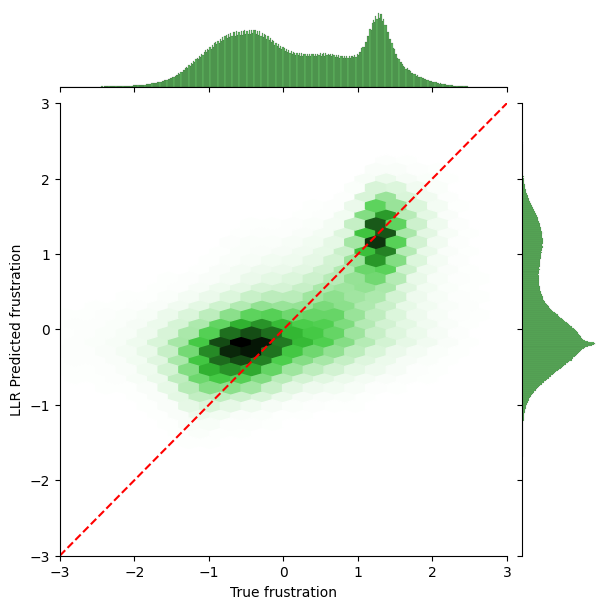

In [29]:
sns.jointplot(x=LLR_test["masked_regr_targets"], y=LLR_test["masked_regr_preds"], kind="hex", xlim=(-3,3), ylim=(-3,3), color="C2")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("LLR Predicted frustration")

### RANDOM SHUFFLE

In [3]:
CNN_test["masked_regr_targets"].shape

(9575120,)

In [4]:
shuffled_masked_targets_cls = np.random.permutation(CNN_test["masked_cls_targets"])
shuffled_masked_targets_regr = np.random.permutation(CNN_test["masked_regr_targets"])
shuffled_masked_targets_regr.shape, shuffled_masked_targets_cls.shape

((9575120,), (9575120,))

In [83]:
bootstrap_regr_cnn = utils.bootstrapping_regression(CNN_test["masked_regr_targets"], CNN_test["masked_regr_preds"], n_bootstrap=100)
bootstrap_regr_cnn["method"] = ["CNN"] * 100

In [84]:
bootstrap_regr_rnd = utils.bootstrapping_regression(CNN_test["masked_regr_targets"], shuffled_masked_targets_regr, n_bootstrap=100)
bootstrap_regr_rnd["method"] = ["Random"] * 100

In [85]:
bootstrap_regr_df = pd.concat([pd.DataFrame(bootstrap_regr_cnn), pd.DataFrame(bootstrap_regr_rnd)])
bootstrap_regr_df.head()

,spearman_r,mae,r2,method
0,0.822030,0.398971,0.675051,CNN
1,0.822145,0.398782,0.675385,CNN
2,0.822131,0.399012,0.675180,CNN
3,0.822083,0.399142,0.675158,CNN
4,0.822109,0.399034,0.675241,CNN


In [86]:
bootstrap_regr_df.to_csv("bootstrap_regr_df.csv", index=False)

<Axes: ylabel='mae'>

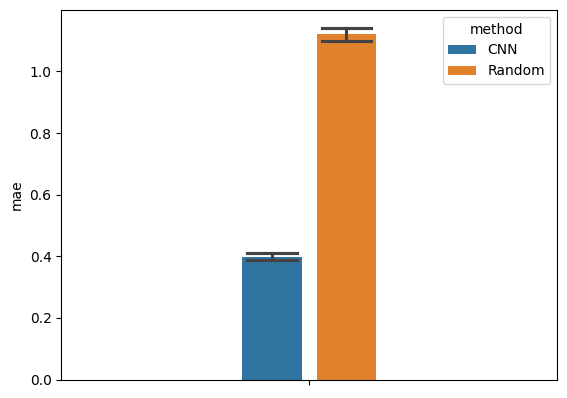

In [82]:
sns.barplot(data=bootstrap_regr_df, hue="method", y="mae", errorbar=("sd", 95), capsize=.2, width=0.3, palette="tab10", gap=0.2)

<Axes: xlabel='method', ylabel='mae'>

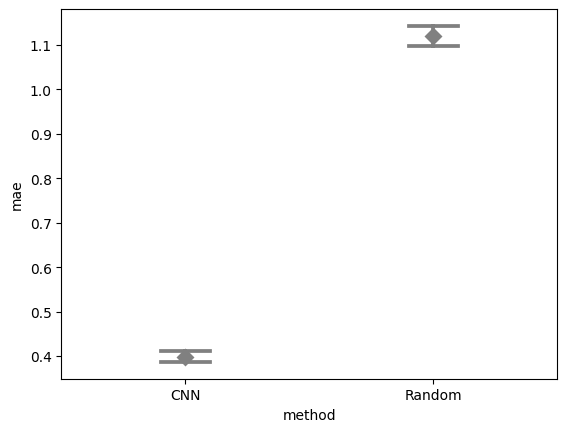

In [61]:
sns.pointplot(data=bootstrap_regr_df, x="method", y="mae", errorbar=("sd", 95), capsize=.2, color=".5", linestyle="none", marker="D")

In [5]:
RND_report = classification_report(CNN_test["masked_cls_targets"], 
                                   shuffled_masked_targets_cls, 
                                   labels=range(3), digits=4, zero_division=0)

In [6]:
print(RND_report)

              precision    recall  f1-score   support

           0     0.1131    0.1131    0.1131   1079124
           1     0.5086    0.5086    0.5086   4868864
           2     0.3790    0.3790    0.3790   3627132

    accuracy                         0.4149   9575120
   macro avg     0.3336    0.3336    0.3336   9575120
weighted avg     0.4149    0.4149    0.4149   9575120



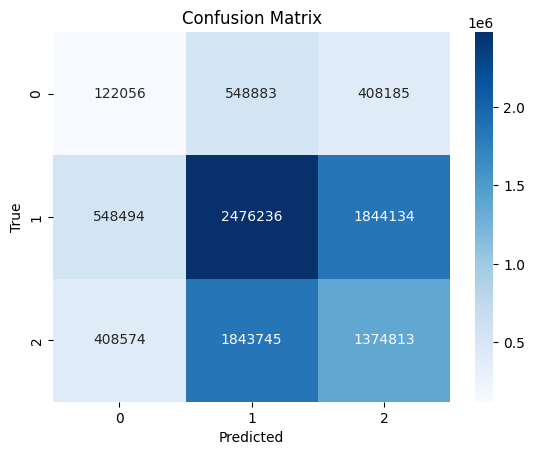

In [9]:
# make a confusion matrix
confusion_matrix = pd.crosstab(CNN_test["masked_cls_targets"], shuffled_masked_targets_cls, rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [10]:
spearmanr(CNN_test["masked_regr_targets"], shuffled_masked_targets_regr)

SignificanceResult(statistic=np.float64(-1.88806137965575e-05), pvalue=np.float64(0.9534112327952416))

In [11]:
mean_absolute_error(CNN_test["masked_regr_targets"], shuffled_masked_targets_regr)

1.1208008527755737

In [12]:
r2_score(CNN_test["masked_regr_targets"], shuffled_masked_targets_regr)

-1.000025749206543

Text(0, 0.5, 'RND Predicted frustration')

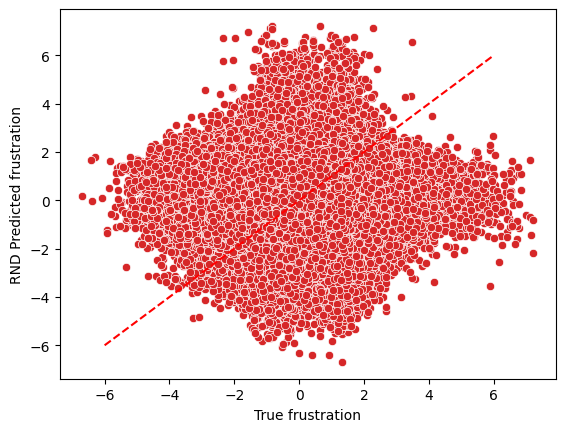

In [30]:
sns.scatterplot(x=CNN_test["masked_regr_targets"], y=shuffled_masked_targets_regr, color="C3")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("RND Predicted frustration")

Text(39.222222222222214, 0.5, 'RND Predicted frustration')

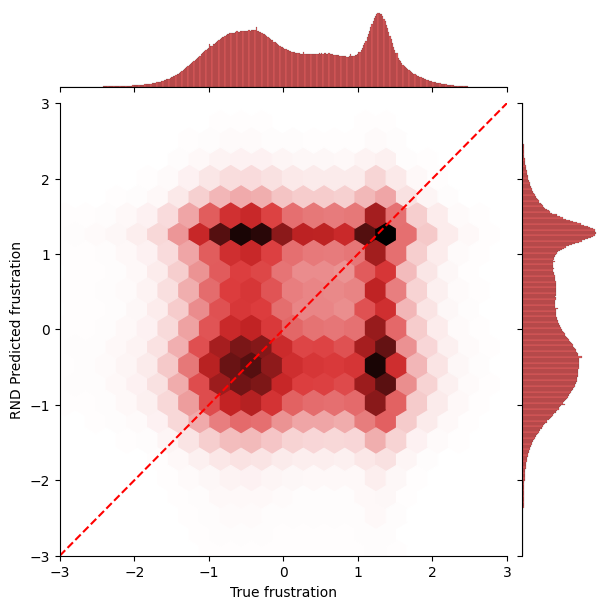

In [31]:
sns.jointplot(x=CNN_test["masked_regr_targets"], y=shuffled_masked_targets_regr, kind="hex", xlim=(-3,3), ylim=(-3,3), color="C3")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("RND Predicted frustration")

### JOINT PLOTS

In [41]:
#create combined dataframe for all models
df_FNN = pd.DataFrame({
    "true": FNN_test["masked_regr_targets"],
    "pred": FNN_test["masked_regr_preds"],
    "model": "FNN"
}).sample(n=100000, random_state=42)
df_CNN = pd.DataFrame({
    "true": CNN_test["masked_regr_targets"],
    "pred": CNN_test["masked_regr_preds"],
    "model": "CNN"
}).sample(n=100000, random_state=42)
df_LLR = pd.DataFrame({
    "true": LLR_test["masked_regr_targets"],
    "pred": LLR_test["masked_regr_preds"],
    "model": "LLR"
}).sample(n=100000, random_state=42)
df_RND = pd.DataFrame({
    "true": FNN_test["masked_regr_targets"],
    "pred": shuffled_masked_targets_regr,
    "model": "RND"
}).sample(n=100000, random_state=42)
df_combined = pd.concat([df_FNN, df_CNN, df_LLR, df_RND], ignore_index=True)
df_combined

,true,pred,model
0,-0.941,-0.779785,FNN
1,-0.280,-0.156982,FNN
2,-0.997,-0.545410,FNN
3,0.732,0.399414,FNN
4,1.699,-0.022629,FNN
...,...,...,...
399995,0.653,-0.172000,RND
399996,1.205,0.279000,RND
399997,-0.421,-0.391000,RND
399998,-1.085,1.239000,RND


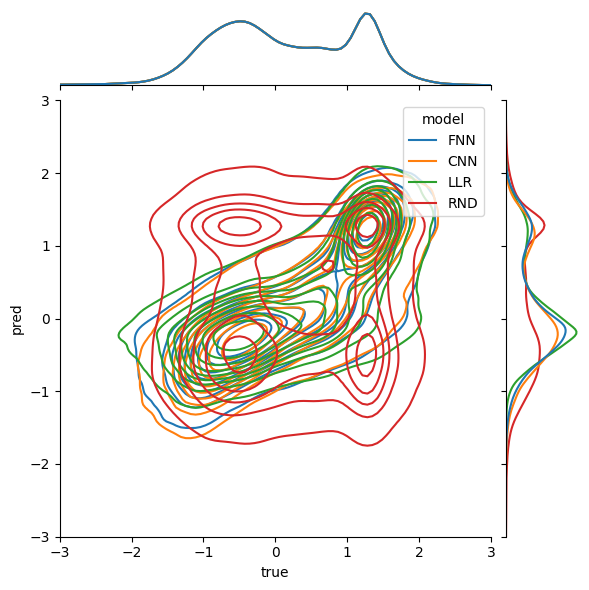

In [42]:
sns.jointplot(data=df_combined, x="true", y="pred", hue="model", kind="kde", xlim=(-3,3), ylim=(-3,3))

In [58]:
metrics = pd.read_csv("../data/it2/metrics.csv")
metrics.head()

,epoch,step,test_ce_loss,test_loss,test_mse_loss,train_ce_loss_epoch,train_ce_loss_step,train_loss_epoch,train_loss_step,train_mse_loss_epoch,train_mse_loss_step,val_ce_loss,val_loss,val_mse_loss
0,0,49,NaN,NaN,NaN,NaN,0.659562,NaN,1.151453,NaN,0.491891,NaN,NaN,NaN
1,0,99,NaN,NaN,NaN,NaN,0.629271,NaN,1.084710,NaN,0.455438,NaN,NaN,NaN
2,0,149,NaN,NaN,NaN,NaN,0.622892,NaN,1.068595,NaN,0.445703,NaN,NaN,NaN
3,0,199,NaN,NaN,NaN,NaN,0.614582,NaN,1.051796,NaN,0.437214,NaN,NaN,NaN
4,0,249,NaN,NaN,NaN,NaN,0.610273,NaN,1.050934,NaN,0.440661,NaN,NaN,NaN


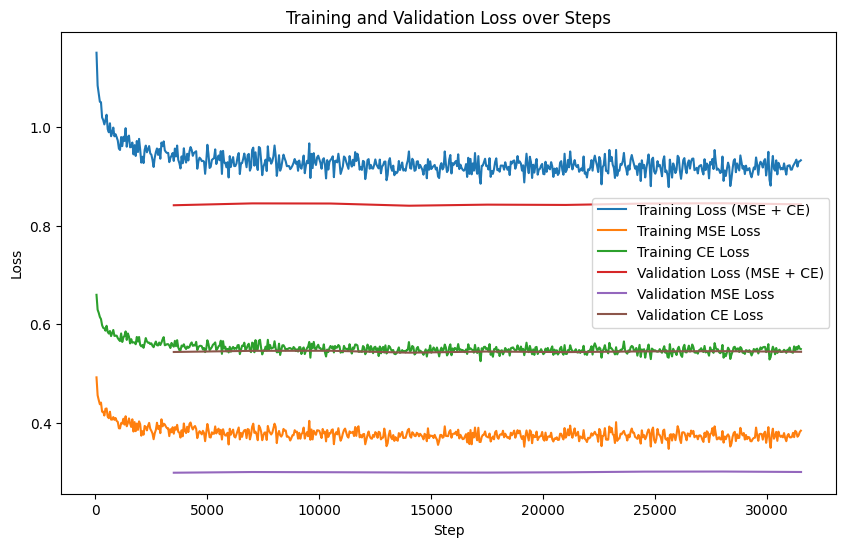

In [68]:
plt.figure(figsize=(10,6))
sns.lineplot(data=metrics, x="step", y="train_loss_step", label="Training Loss (MSE + CE)")
sns.lineplot(data=metrics, x="step", y="train_mse_loss_step", label="Training MSE Loss")
sns.lineplot(data=metrics, x="step", y="train_ce_loss_step", label="Training CE Loss")
sns.lineplot(data=metrics, x="step", y="val_loss", label="Validation Loss (MSE + CE)")
sns.lineplot(data=metrics, x="step", y="val_mse_loss", label="Validation MSE Loss")
sns.lineplot(data=metrics, x="step", y="val_ce_loss", label="Validation CE Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.show()